In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency

In [2]:
# Directory to save figures
figures_dir = "figures"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

# Exploratory Data Analysis

In [3]:
data = pd.read_csv("clinical_data.csv")
data.head()

,patient_id,study_id,sex,age,race,histology,smoking_status,stage,survival_months,survival_status,egfr_mutated,kras_mutated,tp53_mutated
0,tcga-44-4112,nsclc_tcga_broad_2016,female,60.0,caucasian,luad,smoker,stage_1,26.564092,1.0,egfr_neg,kras_neg,tp53_neg
1,tcga-44-5644,nsclc_tcga_broad_2016,female,51.0,caucasian,luad,smoker,stage_1,28.372292,0.0,egfr_neg,kras_neg,tp53_pos
2,tcga-44-5645,nsclc_tcga_broad_2016,female,61.0,african_american,luad,smoker,stage_1,28.010652,0.0,egfr_pos,kras_neg,tp53_pos
3,tcga-44-5643,nsclc_tcga_broad_2016,male,53.0,african_american,luad,smoker,stage_3,33.303745,0.0,egfr_neg,kras_neg,tp53_neg
4,tcga-44-6144,nsclc_tcga_broad_2016,male,58.0,caucasian,luad,smoker,stage_1,23.769603,0.0,egfr_neg,kras_pos,tp53_pos


In [4]:
# Step 1: Overview of the Dataset
print("Dataset shape:", data.shape)
print(data.info())

Dataset shape: (989, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       989 non-null    object 
 1   study_id         989 non-null    object 
 2   sex              989 non-null    object 
 3   age              954 non-null    float64
 4   race             927 non-null    object 
 5   histology        989 non-null    object 
 6   smoking_status   971 non-null    object 
 7   stage            982 non-null    object 
 8   survival_months  955 non-null    float64
 9   survival_status  985 non-null    float64
 10  egfr_mutated     989 non-null    object 
 11  kras_mutated     989 non-null    object 
 12  tp53_mutated     989 non-null    object 
dtypes: float64(3), object(10)
memory usage: 100.6+ KB
None


In [5]:
# Step 2: Feature Distributions
categorical_features = ['sex', 'race', 'stage', 'egfr_mutated', 'kras_mutated', 'tp53_mutated']
numerical_features = ['age']
target1 = ['survival_status']
target2 = ['survival_months']

# print("\nSummary Statistics for Numerical Features:\n", data[numerical_features].describe())

# for feature in categorical_features:
#    print(f"\nValue Counts for {feature}:\n", data[feature].value_counts())

In [6]:
#data = data.dropna()
#data = data[data["race"] != "other"]
#print("Shape after dropping missing values:", data.shape)

In [7]:
# Convert column names to lowercase to handle any inconsistencies
data.columns = data.columns.str.lower()

In [8]:
# Create a frequency table for categorical features and target1
frequency_data = []
for feature in categorical_features + target1:
    feature_counts = data[feature].value_counts().reset_index()
    feature_counts.columns = ['Value', 'Frequency']
    feature_counts['Feature'] = feature
    frequency_data.append(feature_counts)

frequency_table = pd.concat(frequency_data, axis=0, ignore_index=True)[['Feature', 'Value', 'Frequency']]
print("\nFrequency Table for Categorical Features and Target:\n", frequency_table)



Frequency Table for Categorical Features and Target:
             Feature             Value  Frequency
0               sex            female        564
1               sex              male        425
2              race         caucasian        567
3              race             asian        312
4              race  african_american         47
5              race             other          1
6             stage           stage_1        520
7             stage           stage_2        213
8             stage           stage_3        205
9             stage           stage_4         44
10     egfr_mutated          egfr_neg        716
11     egfr_mutated          egfr_pos        273
12     kras_mutated          kras_neg        786
13     kras_mutated          kras_pos        203
14     tp53_mutated          tp53_neg        593
15     tp53_mutated          tp53_pos        396
16  survival_status               0.0        660
17  survival_status               1.0        325


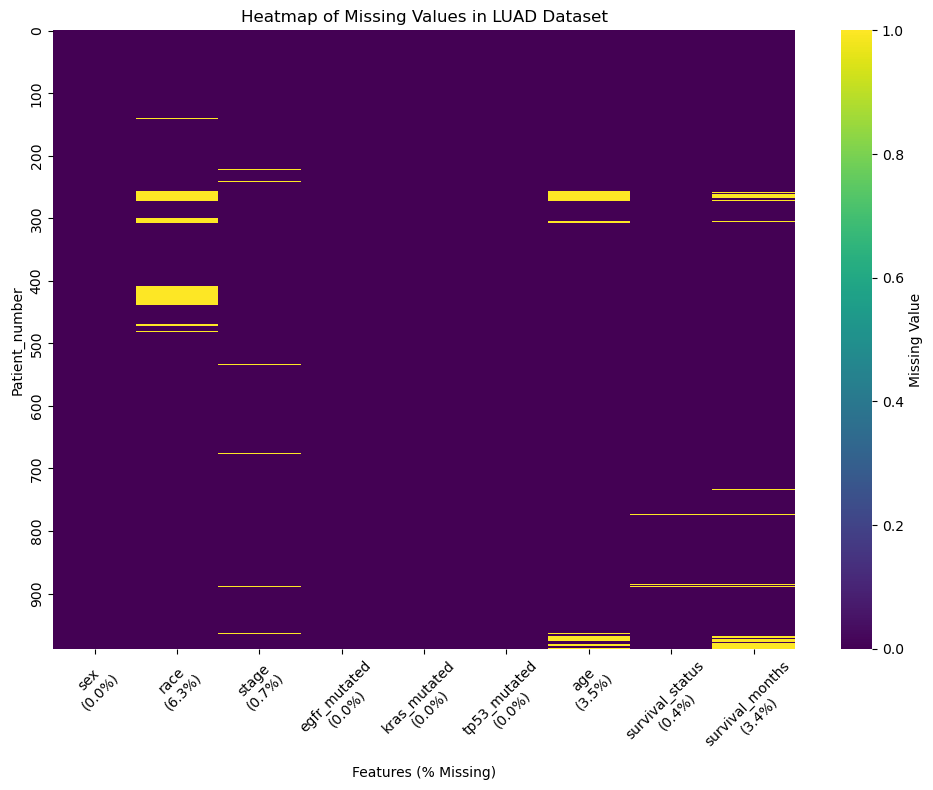

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine all features for missing value analysis
features = categorical_features + numerical_features + target1 + target2
missing_data = data[features].isnull()

# Calculate percentage of missing values for each feature
missing_percentage = missing_data.mean() * 100

# Create figure
plt.figure(figsize=(10, 8))

# Create heatmap
sns.heatmap(missing_data, 
            cmap='viridis', 
            cbar_kws={'label': 'Missing Value'}, 
            yticklabels=100)

# Customize x-axis labels to include the percentage of missing values
plt.xticks(ticks=np.arange(len(features)) + 0.5,  # Add 0.5 to center the labels
           labels=[f"{feature}\n({missing_percentage[feature]:.1f}%)" for feature in features],
           rotation=45,
           ha='center')  # Changed from 'right' to 'center'

plt.xlabel('Features (% Missing)')
plt.ylabel('Patient_number')
plt.title('Heatmap of Missing Values in LUAD Dataset')

# Adjust layout with more bottom margin to prevent label cutoff
plt.tight_layout()

# Save figure

plt.savefig('figures/missing_data_heatmap.png')
plt.show()

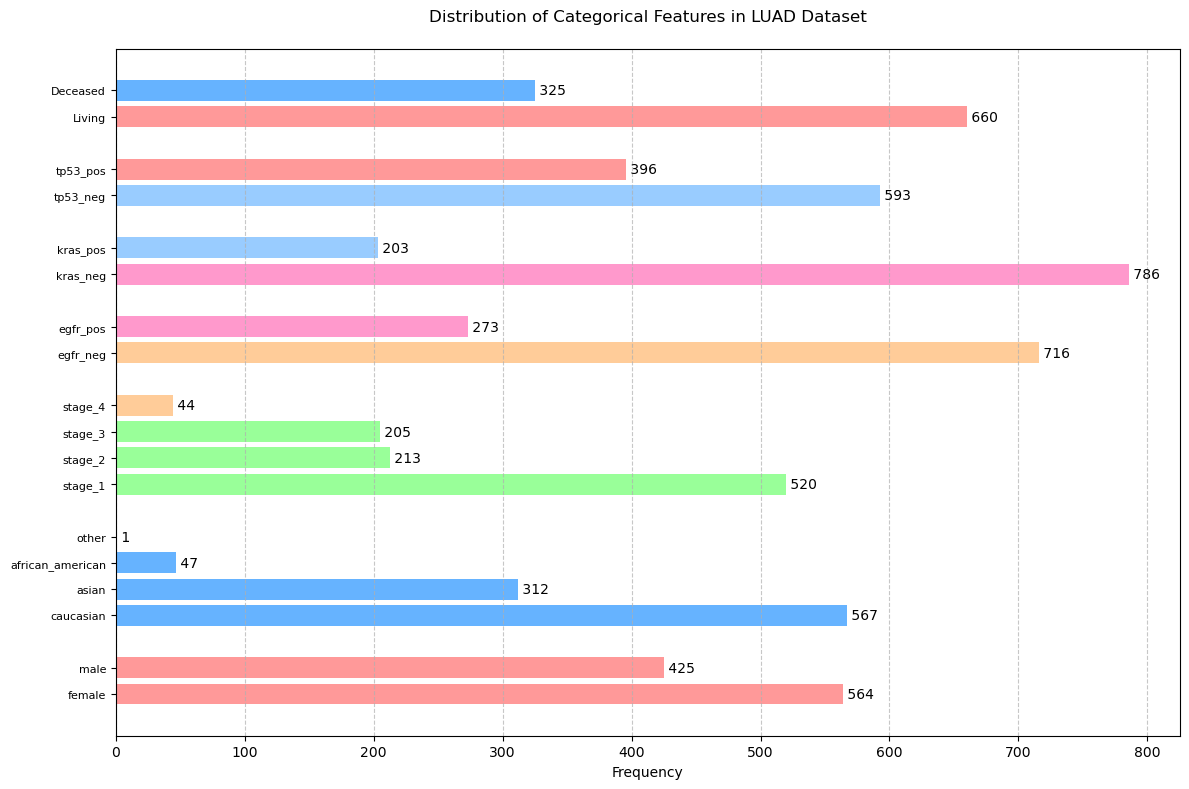

In [17]:
# Plot the frequency table with improved y-axis labels
plt.figure(figsize=(12, 8))

# Create color palette for different features
colors = ['#ff9999', '#ff9999',  # sex
          '#66b3ff', '#66b3ff', '#66b3ff',  # race
          '#99ff99', '#99ff99', '#99ff99', '#99ff99',  # stage
          '#ffcc99', '#ffcc99',  # egfr
          '#ff99cc', '#ff99cc',  # kras
          '#99ccff', '#99ccff']  # tp53

# Create y positions with gaps for grouping
unique_features = frequency_table['Feature'].unique()
y_positions = []
gap = 1  # Gap size between groups
current_position = 0

for feature in unique_features:
    feature_values = frequency_table[frequency_table['Feature'] == feature]
    y_positions.extend(range(current_position, current_position + len(feature_values)))
    current_position += len(feature_values) + gap

# Create horizontal bar plot
bars = plt.barh(y=y_positions, width=frequency_table['Frequency'], color=colors)

# Customize the plot
# Adjusting y-axis labels to only show the value, recode 1.0 to Alive and 0.0 to Deceased for survival_status only
def recode_value(feature, val):
    if feature == 'survival_status':
        if val == 1.0:
            return 'Deceased'
        elif val == 0.0:
            return 'Living'
    return val

plt.yticks(y_positions, 
           [f"{recode_value(feature, val)}" for feature, val in zip(frequency_table['Feature'], frequency_table['Value'])], fontsize=8)

plt.xlabel('Frequency')
plt.title('Distribution of Categorical Features in LUAD Dataset', pad=20)

# Add value labels on the bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f' {int(width)}', 
             va='center', fontsize=10)

# Add grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Save and show the plot
plt.savefig('figures/cat_features_freq.png')
plt.show()


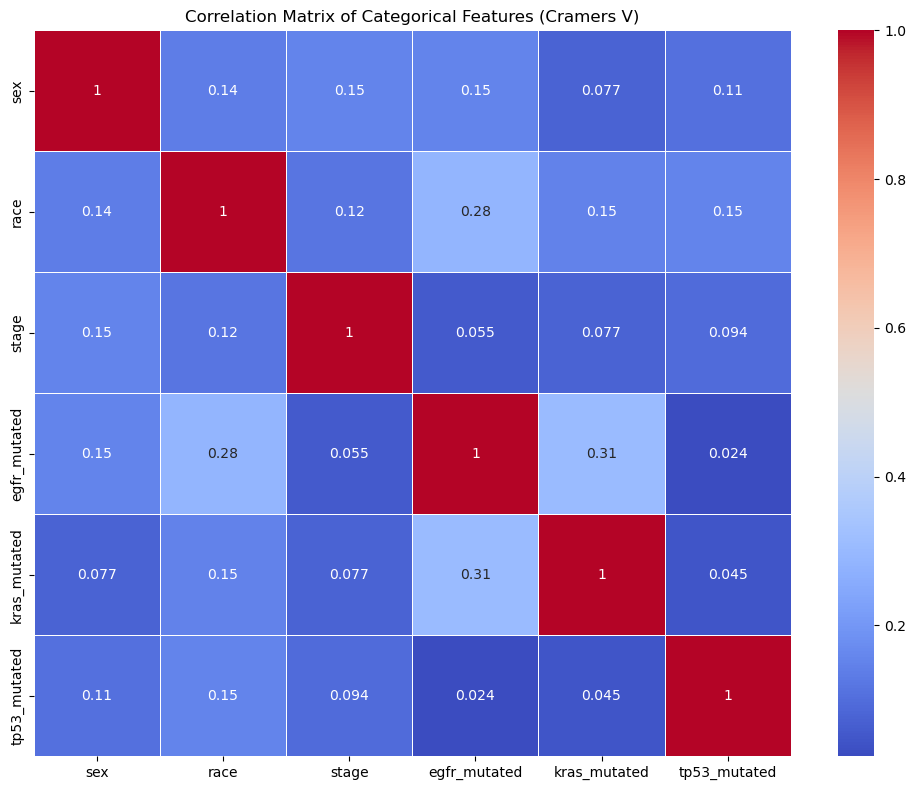

In [18]:
# Step 3: Correlation of Categorical Features
# Encode categorical features for correlation calculation
encoded_data = data[categorical_features].apply(lambda col: LabelEncoder().fit_transform(col))

# Calculate correlation matrix using Cramer's V
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

corr_matrix = pd.DataFrame(index=categorical_features, columns=categorical_features)
for col1 in categorical_features:
    for col2 in categorical_features:
        corr_matrix.loc[col1, col2] = cramers_v(data[col1], data[col2])

corr_matrix = corr_matrix.astype(float)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Categorical Features (Cramers V)')
plt.tight_layout()
plt.savefig('figures/cat_features_corr.png')
plt.show()

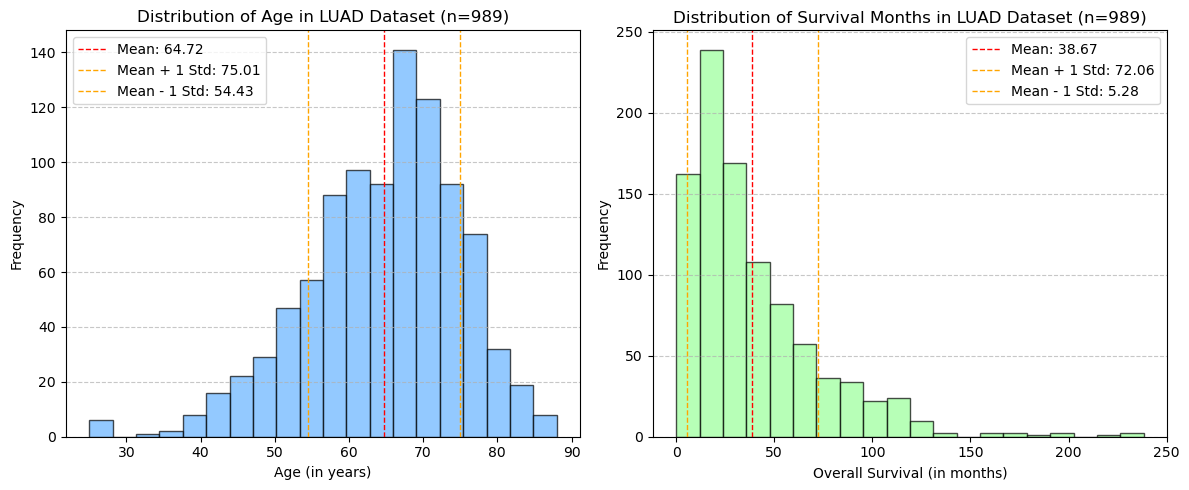

In [19]:
# Plot distribution of age and survival months as subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot distribution of age
axes[0].hist(data['age'], bins=20, color='#66b3ff', edgecolor='black', alpha=0.7)
mean_age = data['age'].mean()
std_age = data['age'].std()
sample_size_age = len(data['age'])
axes[0].axvline(mean_age, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_age:.2f}')
axes[0].axvline(mean_age + std_age, color='orange', linestyle='dashed', linewidth=1, label=f'Mean + 1 Std: {mean_age + std_age:.2f}')
axes[0].axvline(mean_age - std_age, color='orange', linestyle='dashed', linewidth=1, label=f'Mean - 1 Std: {mean_age - std_age:.2f}')
axes[0].set_xlabel('Age (in years)')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Distribution of Age in LUAD Dataset (n={sample_size_age})')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].legend()

# Plot distribution of survival months
axes[1].hist(data['survival_months'], bins=20, color='#99ff99', edgecolor='black', alpha=0.7)
mean_survival = data['survival_months'].mean()
std_survival = data['survival_months'].std()
sample_size_survival = len(data['survival_months'])
axes[1].axvline(mean_survival, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_survival:.2f}')
axes[1].axvline(mean_survival + std_survival, color='orange', linestyle='dashed', linewidth=1, label=f'Mean + 1 Std: {mean_survival + std_survival:.2f}')
axes[1].axvline(mean_survival - std_survival, color='orange', linestyle='dashed', linewidth=1, label=f'Mean - 1 Std: {mean_survival - std_survival:.2f}')
axes[1].set_xlabel('Overall Survival (in months)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Distribution of Survival Months in LUAD Dataset (n={sample_size_survival})')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.savefig('figures/distribution_age_survivaltime.png')
plt.show()


In [13]:
!pip install lifelines

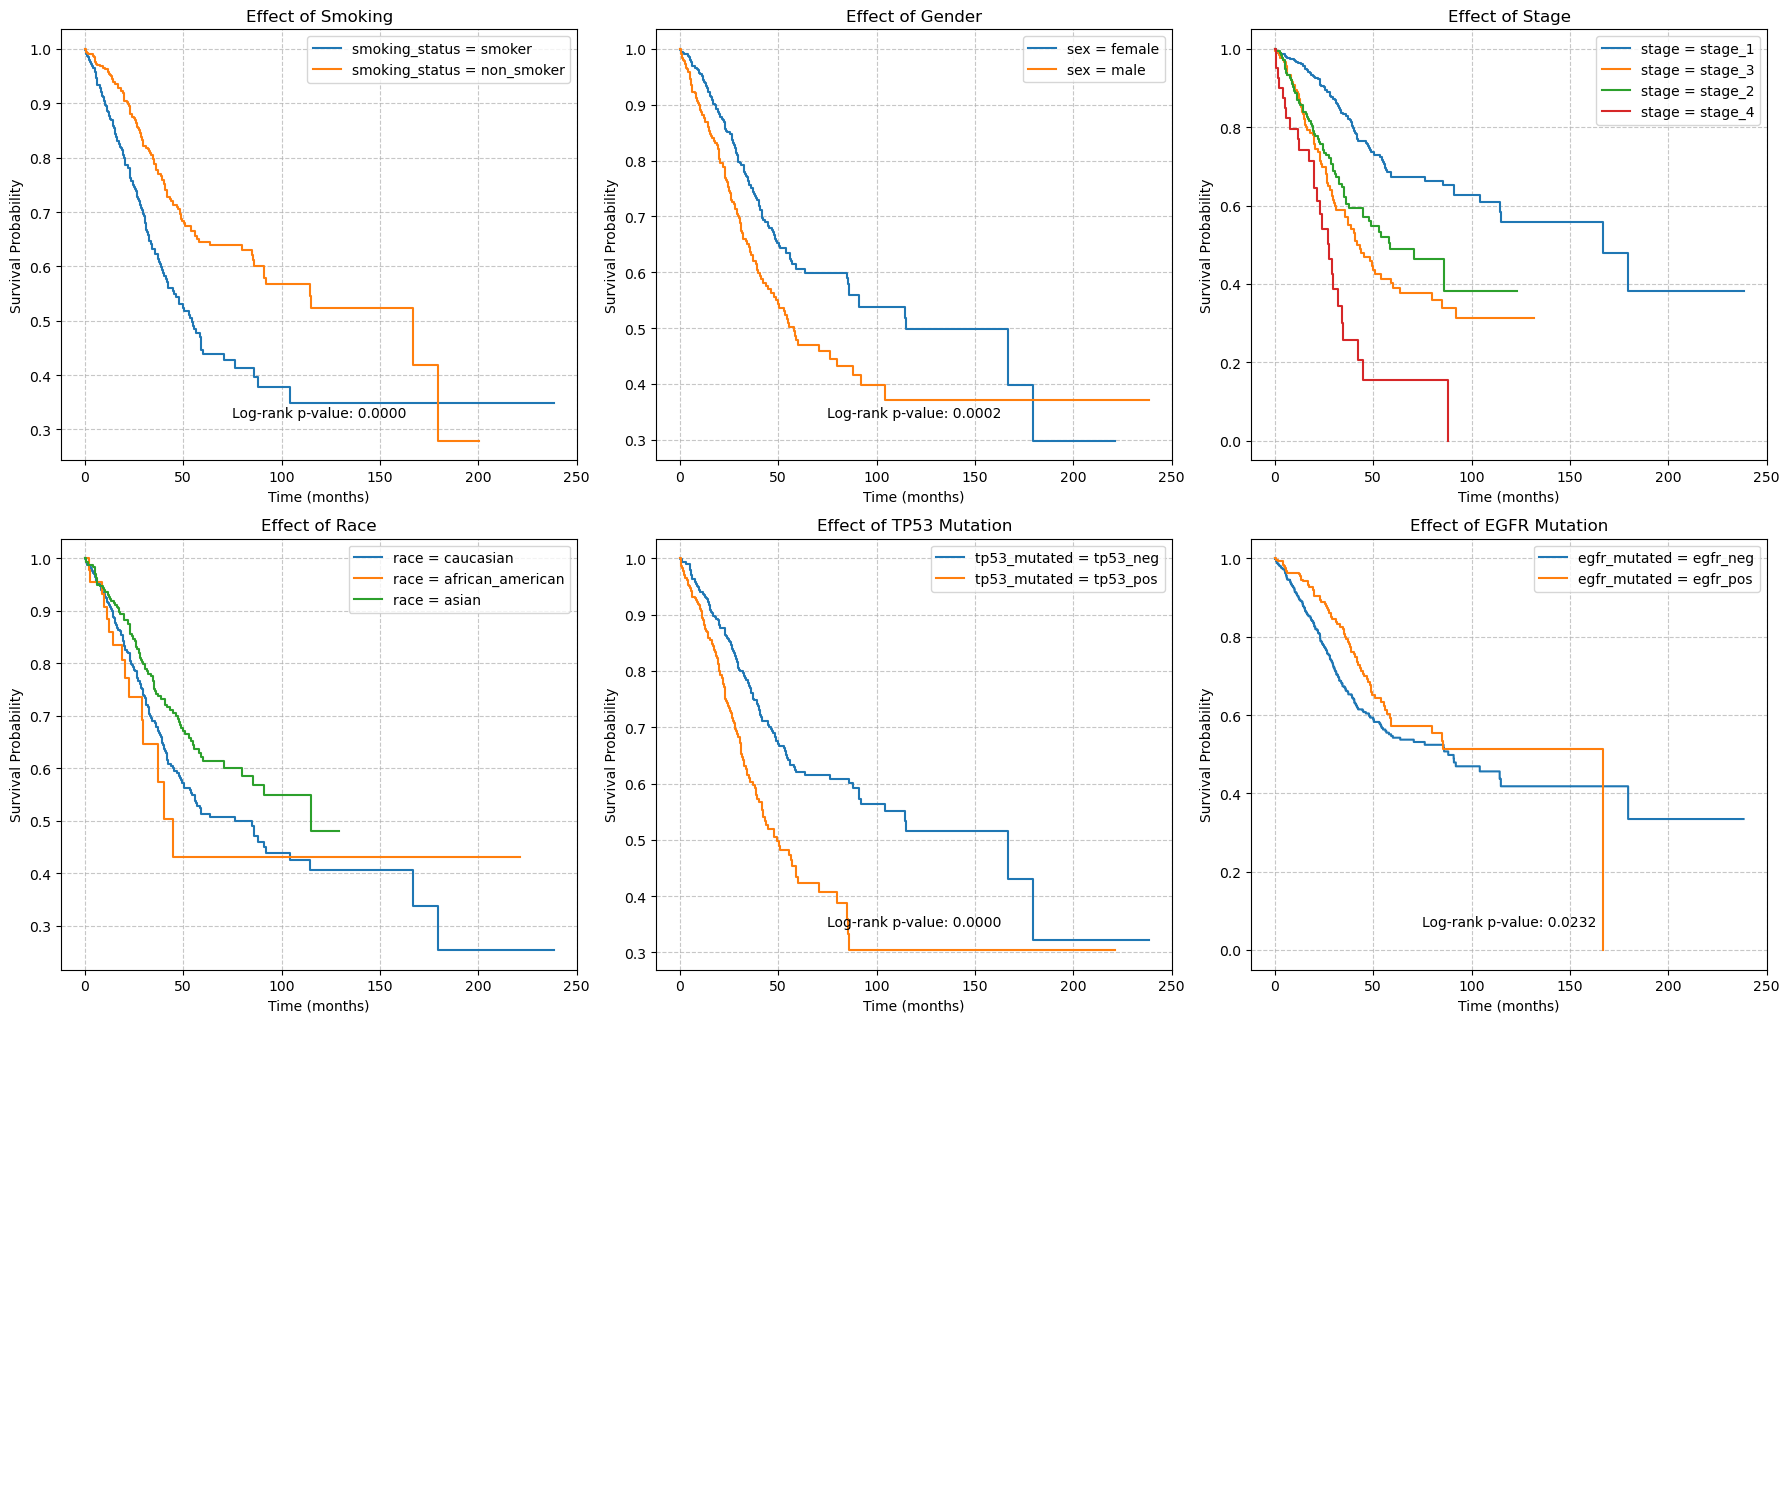

In [20]:
# Kaplan-Meier plots for survival analysis
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Define features to analyze
features_to_analyze = [
    ('smoking_status', 'Effect of Smoking'),
    ('sex', 'Effect of Gender'),
    ('stage', 'Effect of Stage'),
    ('race', 'Effect of Race'),
    ('tp53_mutated', 'Effect of TP53 Mutation'),
    ('egfr_mutated', 'Effect of EGFR Mutation')
]

# Prepare subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

data_clean = data.dropna()
data_clean = data_clean[data_clean["race"] != "other"]

# Survival data
T = data_clean['survival_months']
E = data_clean['survival_status']

# Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Plot Kaplan-Meier curves for each feature
for i, (feature, title) in enumerate(features_to_analyze):
    ax = axes[i]
    unique_values = data_clean[feature].dropna().unique()
    
    for value in unique_values:
        mask = data_clean[feature] == value
        label = f'{feature} = {value}'
        kmf.fit(T[mask], event_observed=E[mask], label=label)
        kmf.plot(ax=ax, ci_show=False)
    
    # Add title and labels
    ax.set_title(title)
    ax.set_xlabel('Time (months)')
    ax.set_ylabel('Survival Probability')
    ax.grid(axis='both', linestyle='--', alpha=0.7)

    # Log-rank test
    if len(unique_values) == 2:
        group1 = T[data_clean[feature] == unique_values[0]]
        group2 = T[data_clean[feature] == unique_values[1]]
        event1 = E[data_clean[feature] == unique_values[0]]
        event2 = E[data_clean[feature] == unique_values[1]]
        result = logrank_test(group1, group2, event_observed_A=event1, event_observed_B=event2)
        ax.text(0.5, 0.1, f'Log-rank p-value: {result.p_value:.4f}', transform=ax.transAxes, ha='center', fontsize=10)

# Adjust layout and add empty subplot titles for any remaining subplots
for j in range(len(features_to_analyze), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('figures/survival_rf_curves_by_feature.png')
plt.show()